In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
gt = pd.read_csv("../../Labelling/Lemurs/LemurID_video_eval/groundtruth.csv", sep = ";")
gt.head()

,video,track_id,individual
0,e1_c4_11_19140_20880.txt,1,Red
1,e1_c4_11_19140_20880.txt,6,Her
2,e1_c4_11_19140_20880.txt,8,Gen
3,e1_c4_14_24360_26100.txt,1,Gen
4,e1_c4_14_24360_26100.txt,3,Flo


In [17]:
#path_to_validation = "../videos/lemur_id_validation_batch/cleaned1"
path_to_validation = "../videos/georg/"
folder_list = sorted([elem for elem in os.listdir(path_to_validation) if not elem.startswith(".")])
folder_list = ['large_scale_model_1']
#folder_list = ['model_'+str(i) for i in range(22, 23)]
#folder_list = ['no_presort', 'hand_picked', 'model', 'distance_1', 'k_means', 'fixed_stepsize']

In [18]:
def count_over_thres(x, thres = 0.3):
    if not x.empty:
        counts = x[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']][x['max'] > thres].idxmax(axis=1).value_counts()
        return counts.reset_index().rename(columns={'index': 'individual', 0: 'count'})
    else:
        return pd.DataFrame({'individual': ['None'], 'count': [0]})



for experiment in folder_list:
    video_list = os.listdir(os.path.join(path_to_validation, experiment))
    video_list = [video for video in video_list if ".txt" in video]

    prediction_df = pd.DataFrame(columns = ['video', 'track_id', 'prediction', 'track_length'])

    for video_name in video_list:
        
        if video_name.endswith(".txt") and "opt" not in video_name:
            df = pd.read_csv(os.path.join(path_to_validation,experiment,video_name), header=None)

            df.columns = ["frame", "track_id", "V3", "V4", "V5", "V6", "conf", "class", "Cha", "Flo", "Gen", "Geo", "Her", "Rab", "Red", "Uns", "ID"]
            df['max'] = df[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max(axis=1)

            filtered_df = df[df['class'] == 0]

            # Group by track and calculate various statistics
            result_df = pd.DataFrame()
            result_df['track_id'] = filtered_df['track_id'].unique()

            # Calculate the individual with the highest average probability across the track
            result_df['highest_avg_individual'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].mean().idxmax(axis=1).values
            result_df['highest_avg_probability'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].mean().max(axis=1).values

            # Calculate the individual with the single highest probability value across the track
            result_df['single_highest_individual'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max().idxmax(axis=1).values
            result_df['single_highest_probability'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max().max(axis=1).values

            # Calculate the individual with the highest number of times getting a probability value over 0.8 within the track
            counts_over_thres = filtered_df[filtered_df['max'] > 0.15].groupby('track_id').apply(count_over_thres, thres = 0.15)
            counts_over_thres2 = filtered_df[filtered_df['max'] > 0.7].groupby('track_id').apply(count_over_thres, thres = 0.7)

            
            if len(counts_over_thres)>0:
                counts_over_thres = counts_over_thres.reset_index(level=1, drop = True)
                if len(counts_over_thres2)>0:
                    counts_over_thres2 = counts_over_thres2.reset_index(level=1, drop = True)
                    merged_df = counts_over_thres.merge(counts_over_thres2, on=['track_id', 'individual'], how='left', suffixes=('', '_Frame2'))
                    merged_df['count'] = merged_df['count'].fillna(0) + merged_df['count_Frame2'].fillna(0) * 100
                    merged_df.drop(columns=['count_Frame2'], inplace=True)
                    merged_df.reset_index(inplace=True)
                    counts_over_thres = merged_df
                    
                counts_over_thres = counts_over_thres.sort_values(by='count', ascending=False).groupby('track_id').first()



                # Merge with result_df using an outer join
                result_df = pd.merge(result_df, counts_over_thres, on='track_id', how='outer')

            else:
                result_df['count'] = 0
                result_df['individual']= ""

            # Add total length of the track
            result_df['track_length'] = filtered_df.groupby('track_id').size().values

            #print(result_df)

            thresholds = {'highest_avg_probability': 0.1, 'single_highest_probability': 0.8, 'count': 1}

            value_cols = ['highest_avg_probability', 'single_highest_probability', 'count']
            name_cols = ['highest_avg_individual', 'single_highest_individual', 'individual']

            values_df = result_df[value_cols].ge(pd.Series(thresholds))
            names_df=result_df[name_cols].fillna('').rename(columns={'highest_avg_individual': 'highest_avg_probability', 'single_highest_individual': 'single_highest_probability', 'individual': 'count'})

            #median of all 3
            result_df['prediction_median'] =names_df.where(values_df, "").replace("", "Uns").apply(lambda row: row.mode().iloc[0], axis = 1)

            #only highest 
            result_df['prediction'] =names_df.where(values_df, "").replace("", "Uns")['count']
            result_df['prediction_singlehighest'] =names_df.where(values_df, "").replace("", "Uns")['single_highest_probability']
            result_df['prediction_avghighest'] =names_df.where(values_df, "").replace("", "Uns")['highest_avg_probability']
            result_df['video'] = video_name
            #print(result_df[['video', 'track_id', 'final']])
            prediction_df = pd.concat([prediction_df, result_df[['video', 'track_id', 'prediction', 'track_length']].fillna("Uns")], ignore_index=True)
        

    names_df.where(values_df, "").replace("", "Uns")

    final_df = pd.merge(gt, prediction_df, on =['video', 'track_id'], how = "left")
    classes = sorted(set(final_df['individual']))#.union(final_df['prediction']))
    cha = False
    if "Cha" in classes:
        classes.remove("Cha")
        cha = True

    # Calculate confusion matrix
    conf_matrix = pd.crosstab(final_df['individual'], final_df['prediction'], rownames=['Actual'], colnames=['Predicted'])

    if cha:
        conf_matrix["Uns"] = conf_matrix["Uns"] + conf_matrix["Cha"]

        # Drop the "Cha" column
        conf_matrix.drop(columns=["Cha"], inplace=True)


    missing_classes = set(classes) - set(conf_matrix.columns)
    for missing_class in missing_classes:
        conf_matrix[missing_class] = 0

    # Sort the columns and index to maintain order
    conf_matrix = conf_matrix[sorted(set(conf_matrix.columns))].sort_index()


    accuracy = np.diag(conf_matrix).sum() / conf_matrix.values.sum()
    print(experiment, "\tAccuracy:", accuracy)

large_scale_model_1 	Accuracy: 0.6739130434782609


In [19]:
np.diag(conf_matrix).sum()
conf_matrix.values.sum()
conf_matrix

Predicted,Flo,Gen,Geo,Her,Rab,Red,Uns
Actual,,,,,,,
Flo,3,0,0,0,0,1,0
Gen,1,15,0,0,0,0,0
Geo,0,0,18,2,0,1,1
Her,1,0,7,8,1,1,1
Rab,0,1,1,2,4,0,1
Red,2,1,0,0,2,14,3


### Random search

In [3]:
path_to_validation = "../videos/lemur_id_randomsearch/"
folder_list = sorted([elem for elem in os.listdir(path_to_validation) if elem.endswith("30")])
folder_list

['ids_exact_0_1.06_1.50_30',
 'ids_exact_10_.57_1.31_30',
 'ids_exact_15_.86_1.16_30',
 'ids_exact_16_.60_1.14_30',
 'ids_exact_17_1.02_1.24_30',
 'ids_exact_17_1.09_1.42_30',
 'ids_exact_18_.83_1.26_30',
 'ids_exact_21_.54_.84_30',
 'ids_exact_23_.86_1.46_30',
 'ids_exact_27_.64_1.48_30',
 'ids_exact_28_.72_1.34_30',
 'ids_exact_28_1.06_1.25_30',
 'ids_exact_31_.69_.95_30',
 'ids_exact_32_.56_1.38_30',
 'ids_exact_35_.73_.90_30',
 'ids_exact_36_1.04_1.39_30',
 'ids_exact_37_.51_1.18_30',
 'ids_exact_39_.55_.94_30',
 'ids_exact_39_.74_1.23_30',
 'ids_exact_42_.53_1.28_30',
 'ids_exact_43_.83_1.37_30',
 'ids_exact_44_.62_1.15_30',
 'ids_exact_48_.63_1.41_30',
 'ids_exact_50_.90_1.13_30',
 'ids_exact_51_.70_1.20_30',
 'ids_exact_52_.53_1.23_30',
 'ids_exact_53_1.02_1.11_30',
 'ids_exact_54_.77_1.04_30',
 'ids_exact_57_.95_1.39_30',
 'ids_exact_59_.85_1.37_30',
 'ids_exact_5_1.08_1.31_30',
 'ids_exact_61_1.05_1.33_30',
 'ids_exact_64_.66_1.19_30',
 'ids_exact_66_.52_1.10_30',
 'ids_exact_

In [4]:
df_out = pd.DataFrame(columns=['cutout', 'move', 'zoom_min', 'zoom_max', 'epoch'])

# Iterate through the folder list, split the names, and append to the DataFrame
for folder_name in folder_list:
    parts = folder_name.split('_')
    df_out = df_out.append(pd.Series(parts[1:], index=df_out.columns), ignore_index=True)
df_out['accuracy'] = 0.0
df_out

,cutout,move,zoom_min,zoom_max,epoch,accuracy
0,exact,0,1.06,1.50,30,0.0
1,exact,10,.57,1.31,30,0.0
2,exact,15,.86,1.16,30,0.0
3,exact,16,.60,1.14,30,0.0
4,exact,17,1.02,1.24,30,0.0
...,...,...,...,...,...,...
95,square,91,.76,.93,30,0.0
96,square,94,.75,.93,30,0.0
97,square,95,.87,1.46,30,0.0
98,square,98,.71,1.12,30,0.0


In [40]:



for i, experiment in enumerate(folder_list):
    video_list = os.listdir(os.path.join(path_to_validation, experiment))

    prediction_df = pd.DataFrame(columns = ['video', 'track_id', 'prediction', 'track_length'])

    for video_name in video_list:
        
        if video_name.endswith(".txt") and "opt" not in video_name:
            df = pd.read_csv(os.path.join(path_to_validation,experiment,video_name), header=None)

            df.columns = ["frame", "track_id", "V3", "V4", "V5", "V6", "conf", "class", "Cha", "Flo", "Gen", "Geo", "Her", "Rab", "Red", "Uns", "max", "ID"]
            df['max'] = df[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max(axis=1)

            filtered_df = df[df['class'] == 0]

            # Group by track and calculate various statistics
            result_df = pd.DataFrame()
            result_df['track_id'] = filtered_df['track_id'].unique()

            # Calculate the individual with the highest average probability across the track
            result_df['highest_avg_individual'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].mean().idxmax(axis=1).values
            result_df['highest_avg_probability'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].mean().max(axis=1).values

            # Calculate the individual with the single highest probability value across the track
            result_df['single_highest_individual'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max().idxmax(axis=1).values
            result_df['single_highest_probability'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max().max(axis=1).values

            # Calculate the individual with the highest number of times getting a probability value over 0.8 within the track
            counts_over_thres = filtered_df[filtered_df['max'] > 0.6].groupby('track_id').apply(lambda x: x[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].idxmax(axis=1).value_counts().reset_index().rename(columns={'index': 'individual', 0: 'count'}) if not x.empty else pd.DataFrame({'individual': ['None'], 'count': [0]}))
            counts_over_thres2 = filtered_df[filtered_df['max'] > 0.95].groupby('track_id').apply(lambda x: x[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].idxmax(axis=1).value_counts().reset_index().rename(columns={'index': 'individual', 0: 'count'}) if not x.empty else pd.DataFrame({'individual': ['None'], 'count': [0]}))
            
            if len(counts_over_thres)>0:
                counts_over_thres = counts_over_thres.reset_index(level=1, drop = True)
                counts_over_thres2 = counts_over_thres2.reset_index(level=1, drop = True)
                counts_over_thres = counts_over_thres + counts_over_thres2 * 100
                counts_over_thres = counts_over_thres.sort_values(by='count', ascending=False).groupby('track_id').first()

                # Merge with result_df using an outer join
                result_df = pd.merge(result_df, counts_over_thres, on='track_id', how='outer')

            else:
                result_df['count'] = 0
                result_df['individual']= ""

            # Add total length of the track
            result_df['track_length'] = filtered_df.groupby('track_id').size().values

            #print(result_df)

            thresholds = {'highest_avg_probability': 0.1, 'single_highest_probability': 0.8, 'count': 1}

            value_cols = ['highest_avg_probability', 'single_highest_probability', 'count']
            name_cols = ['highest_avg_individual', 'single_highest_individual', 'individual']

            values_df = result_df[value_cols].ge(pd.Series(thresholds))
            names_df=result_df[name_cols].fillna('').rename(columns={'highest_avg_individual': 'highest_avg_probability', 'single_highest_individual': 'single_highest_probability', 'individual': 'count'})

            #median of all 3
            result_df['prediction_median'] =names_df.where(values_df, "").replace("", "Uns").apply(lambda row: row.mode().iloc[0], axis = 1)

            #only highest 
            result_df['prediction'] =names_df.where(values_df, "").replace("", "Uns")['count']
            result_df['prediction_singlehighest'] =names_df.where(values_df, "").replace("", "Uns")['single_highest_probability']
            result_df['prediction_avghighest'] =names_df.where(values_df, "").replace("", "Uns")['highest_avg_probability']
            result_df['video'] = video_name
            #print(result_df[['video', 'track_id', 'final']])
            prediction_df = pd.concat([prediction_df, result_df[['video', 'track_id', 'prediction', 'track_length']].fillna("Uns")], ignore_index=True)
        

    names_df.where(values_df, "").replace("", "Uns")

    final_df = pd.merge(gt, prediction_df, on =['video', 'track_id'], how = "left")
    classes = sorted(set(final_df['individual']).union(final_df['prediction']))
    cha = False
    if "Cha" in classes:
        classes.remove("Cha")
        cha = True

    # Calculate confusion matrix
    conf_matrix = pd.crosstab(final_df['individual'], final_df['prediction'], rownames=['Actual'], colnames=['Predicted'])

    if cha:
        conf_matrix["Uns"] = conf_matrix["Uns"] + conf_matrix["Cha"]

        # Drop the "Cha" column
        conf_matrix.drop(columns=["Cha"], inplace=True)


    missing_classes = set(classes) - set(conf_matrix.columns)
    for missing_class in missing_classes:
        conf_matrix[missing_class] = 0

    # Sort the columns and index to maintain order
    conf_matrix = conf_matrix[sorted(set(conf_matrix.columns))].sort_index()


    accuracy = np.diag(conf_matrix).sum() / conf_matrix.values.sum()
    df_out.at[i, 'accuracy'] = accuracy
    #print(experiment, "\tAccuracy:", accuracy)

IndexError: Too many levels: Index has only 1 level, not 2

In [ ]:
df_out

numeric_columns = ['move', 'zoom_min', 'zoom_max', 'epoch', 'accuracy']  # List of columns to convert
df_out[numeric_columns] = df_out[numeric_columns].apply(pd.to_numeric)
df_out

,cutout,move,zoom_min,zoom_max,epoch,accuracy
0,exact,0,1.06,1.50,30,0.804348
1,exact,10,0.57,1.31,30,0.804348
2,exact,15,0.86,1.16,30,0.771739
3,exact,16,0.60,1.14,30,0.728261
4,exact,17,1.02,1.24,30,0.793478
...,...,...,...,...,...,...
95,square,91,0.76,0.93,30,0.706522
96,square,94,0.75,0.93,30,0.619565
97,square,95,0.87,1.46,30,0.717391
98,square,98,0.71,1.12,30,0.673913


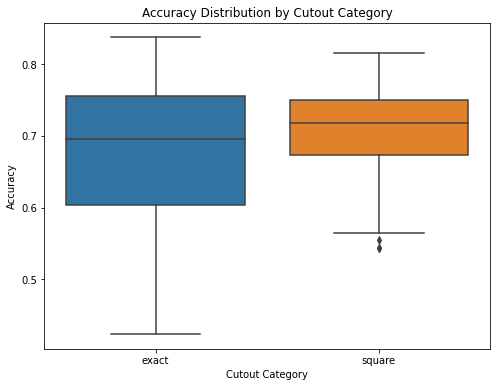

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='cutout', y='accuracy', data=df_out)
plt.title('Accuracy Distribution by Cutout Category')
plt.xlabel('Cutout Category')
plt.ylabel('Accuracy')
plt.show()

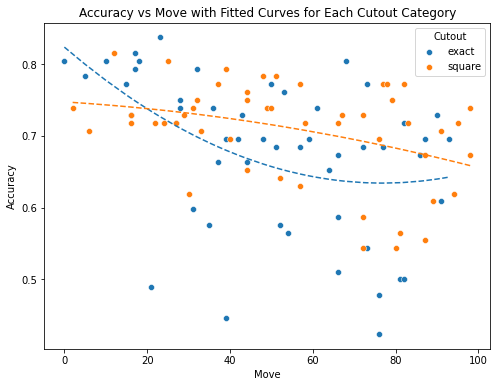

In [ ]:
plt.figure(figsize=(8, 6))
#sns.scatterplot(x='move', y='accuracy', hue='cutout', data=df_out, palette='Set2')


for group, data_group in df_out.groupby('cutout'):
    sns.scatterplot(x='move', y='accuracy', data=data_group, label=group)
    x = data_group['move']
    y = data_group['accuracy']
    coefficients = np.polyfit(x, y, 2)
    fitted_curve = np.poly1d(coefficients)
    plt.plot(sorted(x), fitted_curve(sorted(x)), linestyle='--')

plt.title('Accuracy vs Move with Fitted Curves for Each Cutout Category')
plt.xlabel('Move')
plt.ylabel('Accuracy')
plt.legend(title='Cutout')

plt.show()

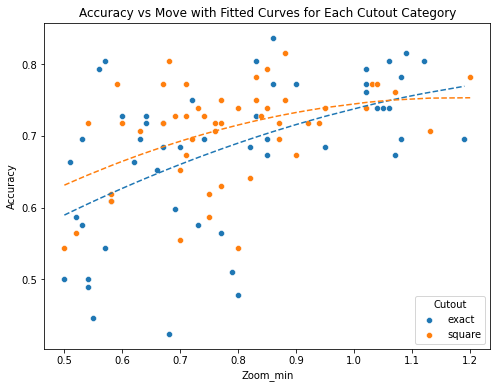

In [ ]:
plt.figure(figsize=(8, 6))
#sns.scatterplot(x='move', y='accuracy', hue='cutout', data=df_out, palette='Set2')


for group, data_group in df_out.groupby('cutout'):
    sns.scatterplot(x='zoom_min', y='accuracy', data=data_group, label=group)
    x = data_group['zoom_min']
    y = data_group['accuracy']
    coefficients = np.polyfit(x, y, 2)
    fitted_curve = np.poly1d(coefficients)
    plt.plot(sorted(x), fitted_curve(sorted(x)), linestyle='--')

plt.title('Accuracy vs Move with Fitted Curves for Each Cutout Category')
plt.xlabel('Zoom_min')
plt.ylabel('Accuracy')
plt.legend(title='Cutout')

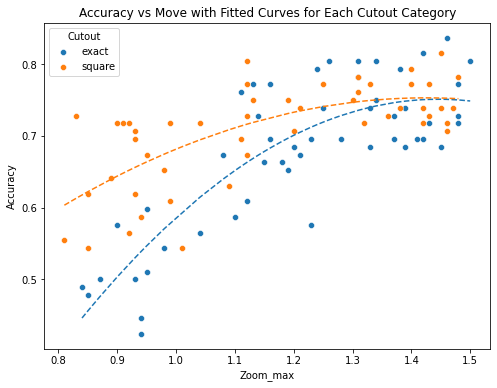

In [ ]:
plt.figure(figsize=(8, 6))
#sns.scatterplot(x='move', y='accuracy', hue='cutout', data=df_out, palette='Set2')


for group, data_group in df_out.groupby('cutout'):
    sns.scatterplot(x='zoom_max', y='accuracy', data=data_group, label=group)
    x = data_group['zoom_max']
    y = data_group['accuracy']
    coefficients = np.polyfit(x, y, 2)
    fitted_curve = np.poly1d(coefficients)
    plt.plot(sorted(x), fitted_curve(sorted(x)), linestyle='--')

plt.title('Accuracy vs Move with Fitted Curves for Each Cutout Category')
plt.xlabel('Zoom_max')
plt.ylabel('Accuracy')
plt.legend(title='Cutout')

/tmp/ipykernel_44681/918276621.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['zoom_min_bin'] = pd.cut(df_filtered['zoom_min'], bins=bin_edges_min)
/tmp/ipykernel_44681/918276621.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['zoom_max_bin'] = pd.cut(df_filtered['zoom_max'], bins=bin_edges_max)


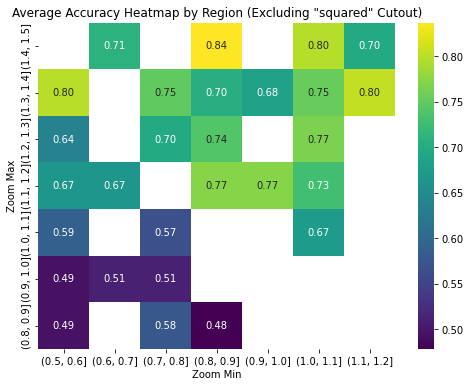

In [ ]:
df_filtered = df_out[df_out['cutout']=="exact"]

min_zoom_min = df_filtered['zoom_min'].min()
max_zoom_min = df_filtered['zoom_min'].max()
min_zoom_max = df_filtered['zoom_max'].min()
max_zoom_max = df_filtered['zoom_max'].max()

# Round down the minimum value to the nearest 0.1 and round up the maximum value to the nearest 0.1
min_zoom_min = np.floor(min_zoom_min * 10) / 10
max_zoom_min = np.ceil(max_zoom_min * 10) / 10
min_zoom_max = np.floor(min_zoom_max * 10) / 10
max_zoom_max = np.ceil(max_zoom_max * 10) / 10

# Generate bin edges with a step size of 0.2 starting from the rounded minimum value
bin_edges_min = np.arange(min_zoom_min, max_zoom_min + 0.1, 0.1)
bin_edges_max = np.arange(min_zoom_max, max_zoom_max + 0.1, 0.1)

# Calculate average accuracy for each region
df_filtered['zoom_min_bin'] = pd.cut(df_filtered['zoom_min'], bins=bin_edges_min)
df_filtered['zoom_max_bin'] = pd.cut(df_filtered['zoom_max'], bins=bin_edges_max)
heatmap_data = df_filtered.groupby(['zoom_min_bin', 'zoom_max_bin'])['accuracy'].mean().reset_index()



# Pivot the data for heatmap
heatmap_pivot = heatmap_data.pivot('zoom_max_bin', 'zoom_min_bin', 'accuracy')

heatmap_pivot = heatmap_pivot.iloc[::-1]

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_pivot, annot=True, cmap='viridis', fmt='.2f')
plt.title('Average Accuracy Heatmap by Region (Excluding "squared" Cutout)')
plt.xlabel('Zoom Min')
plt.ylabel('Zoom Max')
plt.show()

In [ ]:
df_out.sort_values("accuracy").tail(10)

,cutout,move,zoom_min,zoom_max,epoch,accuracy
4,exact,17,1.02,1.24,30,0.793478
65,square,39,0.85,1.40,30,0.793478
36,exact,68,1.12,1.34,30,0.804348
56,square,25,0.68,1.12,30,0.804348
6,exact,18,0.83,1.26,30,0.804348
1,exact,10,0.57,1.31,30,0.804348
0,exact,0,1.06,1.50,30,0.804348
51,square,12,0.88,1.45,30,0.815217
5,exact,17,1.09,1.42,30,0.815217
8,exact,23,0.86,1.46,30,0.836957


/tmp/ipykernel_44681/4009956103.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['zoom_min_bin'] = pd.cut(df_filtered['move'], bins=bin_edges_min)
/tmp/ipykernel_44681/4009956103.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['zoom_max_bin'] = pd.cut(df_filtered['zoom_max'], bins=bin_edges_max)


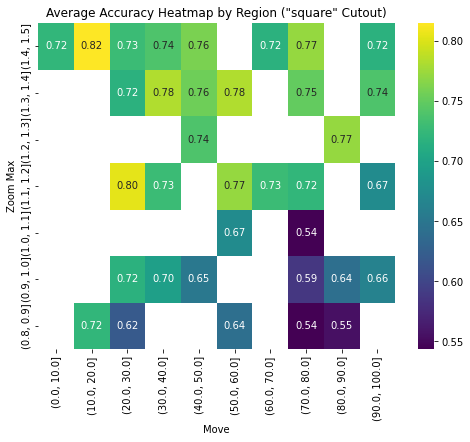

In [ ]:
df_filtered = df_out[df_out['cutout']=="square"]

min_zoom_min = df_filtered['move'].min()
max_zoom_min = df_filtered['move'].max()
min_zoom_max = df_filtered['zoom_max'].min()
max_zoom_max = df_filtered['zoom_max'].max()

# Round down the minimum value to the nearest 0.1 and round up the maximum value to the nearest 0.1
min_zoom_min = np.floor(min_zoom_min / 10) * 10 
max_zoom_min = np.ceil(max_zoom_min / 10) * 10
min_zoom_max = np.floor(min_zoom_max * 10) / 10
max_zoom_max = np.ceil(max_zoom_max * 10) / 10

# Generate bin edges with a step size of 0.2 starting from the rounded minimum value
bin_edges_min = np.arange(min_zoom_min, max_zoom_min + 10, 10)
bin_edges_max = np.arange(min_zoom_max, max_zoom_max + 0.1, 0.1)

# Calculate average accuracy for each region
df_filtered['zoom_min_bin'] = pd.cut(df_filtered['move'], bins=bin_edges_min)
df_filtered['zoom_max_bin'] = pd.cut(df_filtered['zoom_max'], bins=bin_edges_max)
heatmap_data = df_filtered.groupby(['zoom_min_bin', 'zoom_max_bin'])['accuracy'].mean().reset_index()



# Pivot the data for heatmap
heatmap_pivot = heatmap_data.pivot('zoom_max_bin', 'zoom_min_bin', 'accuracy')

heatmap_pivot = heatmap_pivot.iloc[::-1]

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_pivot, annot=True, cmap='viridis', fmt='.2f')
plt.title('Average Accuracy Heatmap by Region ("square" Cutout)')
plt.xlabel('Move')
plt.ylabel('Zoom Max')
plt.show()

In [15]:
#deprecated
for experiment in folder_list:
    video_list = os.listdir(os.path.join(path_to_validation, experiment))
    video_list = [video for video in video_list if ".txt" in video]

    prediction_df = pd.DataFrame(columns = ['video', 'track_id', 'prediction', 'track_length'])

    for video_name in video_list:
        
        if video_name.endswith(".txt") and "opt" not in video_name:
            df = pd.read_csv(os.path.join(path_to_validation,experiment,video_name), header=None)

            df.columns = ["frame", "track_id", "V3", "V4", "V5", "V6", "conf", "class", "Cha", "Flo", "Gen", "Geo", "Her", "Rab", "Red", "Uns", "ID"]
            df['max'] = df[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max(axis=1)

            filtered_df = df[df['class'] == 0]

            # Group by track and calculate various statistics
            result_df = pd.DataFrame()
            result_df['track_id'] = filtered_df['track_id'].unique()

            # Calculate the individual with the highest average probability across the track
            result_df['highest_avg_individual'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].mean().idxmax(axis=1).values
            result_df['highest_avg_probability'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].mean().max(axis=1).values

            # Calculate the individual with the single highest probability value across the track
            result_df['single_highest_individual'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max().idxmax(axis=1).values
            result_df['single_highest_probability'] = filtered_df.groupby('track_id')[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].max().max(axis=1).values

            # Calculate the individual with the highest number of times getting a probability value over 0.8 within the track
            counts_over_thres = filtered_df[filtered_df['max'] > 0.3].groupby('track_id').apply(lambda x: x[['Cha', 'Flo', 'Gen', 'Geo', 'Her', 'Rab', 'Red']].idxmax(axis=1).value_counts().reset_index().rename(columns={'index': 'individual', 0: 'count'}) if not x.empty else pd.DataFrame({'individual': ['None'], 'count': [0]}))
            if len(counts_over_thres)>0:
                counts_over_thres = counts_over_thres.reset_index(level=1, drop = True)
                counts_over_thres = counts_over_thres.sort_values(by='count', ascending=False).groupby('track_id').first()

                # Merge with result_df using an outer join
                result_df = pd.merge(result_df, counts_over_thres, on='track_id', how='outer')

            else:
                result_df['count'] = 0
                result_df['individual']= ""

            # Add total length of the track
            result_df['track_length'] = filtered_df.groupby('track_id').size().values

            #print(result_df)

            thresholds = {'highest_avg_probability': 0.1, 'single_highest_probability': 0.8, 'count': 1}

            value_cols = ['highest_avg_probability', 'single_highest_probability', 'count']
            name_cols = ['highest_avg_individual', 'single_highest_individual', 'individual']

            values_df = result_df[value_cols].ge(pd.Series(thresholds))
            names_df=result_df[name_cols].fillna('').rename(columns={'highest_avg_individual': 'highest_avg_probability', 'single_highest_individual': 'single_highest_probability', 'individual': 'count'})

            #median of all 3
            result_df['prediction_median'] =names_df.where(values_df, "").replace("", "Uns").apply(lambda row: row.mode().iloc[0], axis = 1)

            #only highest 
            result_df['prediction'] =names_df.where(values_df, "").replace("", "Uns")['count']
            result_df['prediction_singlehighest'] =names_df.where(values_df, "").replace("", "Uns")['single_highest_probability']
            result_df['prediction_avghighest'] =names_df.where(values_df, "").replace("", "Uns")['highest_avg_probability']
            result_df['video'] = video_name
            #print(result_df[['video', 'track_id', 'final']])
            prediction_df = pd.concat([prediction_df, result_df[['video', 'track_id', 'prediction', 'track_length']].fillna("Uns")], ignore_index=True)
        

    names_df.where(values_df, "").replace("", "Uns")

    final_df = pd.merge(gt, prediction_df, on =['video', 'track_id'], how = "left")
    classes = sorted(set(final_df['individual']))#.union(final_df['prediction']))
    cha = False
    if "Cha" in classes:
        classes.remove("Cha")
        cha = True

    # Calculate confusion matrix
    conf_matrix = pd.crosstab(final_df['individual'], final_df['prediction'], rownames=['Actual'], colnames=['Predicted'])

    if cha:
        conf_matrix["Uns"] = conf_matrix["Uns"] + conf_matrix["Cha"]

        # Drop the "Cha" column
        conf_matrix.drop(columns=["Cha"], inplace=True)


    missing_classes = set(classes) - set(conf_matrix.columns)
    for missing_class in missing_classes:
        conf_matrix[missing_class] = 0

    # Sort the columns and index to maintain order
    conf_matrix = conf_matrix[sorted(set(conf_matrix.columns))].sort_index()


    accuracy = np.diag(conf_matrix).sum() / conf_matrix.values.sum()
    print(experiment, "\tAccuracy:", accuracy)

model_22 	Accuracy: 0.8260869565217391
